# Product matching

In 2021-2022 heb ik voor een klant gewerkt aan een product matching oplossing (i.e. het vinden van vergelijkbare producten). Ik heb geen code meer van dat project, dus ik heb opnieuw data verzameld en code geschreven. Dit notebook beschrijft het doel van het project en laat code componenten zien.

## Doel

De klant heeft als belofte aan de consument voordelig geprijsd te zijn. Om die belofte na te komen en te verifieren willen ze hun eigen prijzen vergelijken met concurrenten. Voor die vergelijking moeten ze eerst vergelijkbare producten bij concurrenten vinden. Vervolgens kan een distributie van prijzen worden gemaakt, het percentiel van de prijs van de klant worden bepaald en de prijs eventueel worden aangepast.

Dit notebook focust op het vinden van vergelijkbare producten.

## Process

Het proces ziet er ongeveer als volgt uit:

1. Dataverzameling
1. Data cleaning
2. Converteren van data naar tensors
3. Similarity measure tussen tensors
4. Combineren van similarity measure tot eind score

De notebook beschrijft de stappen in meer detail.

## Verbeteringen

- meer data scrapen
- LSH
- alle modellen combineren tot één model
- betere/ nieuwe modellen

In [284]:
import html
import os
import pprint
import re
import shutil
import sqlite3
from io import StringIO
from math import prod

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

c:\Users\ADMINVIVO\Desktop\product_matching_demo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Dataverzameling

Ik heb data verzameld van Albert Heijn. Dit was geen klant of concurrent, maar leek me een goed alternatief.

### Techniek

Data is verzameld dmv Scrapy. Code wordt niet besproken in dit notebook. De repo is hier te vinden: TODO.

### Data beschrijving

Verzamelde data:
- url
- id
- titel
- foto
- beschrijving
- voedingswaarde

In [2]:
# werk met copy van originele data

db_path_orig = "data/products_orig.sqlite"
db_path = "data/products_copy.sqlite"

table_name = "products"

shutil.copy(db_path_orig, db_path)

'data/products_copy.sqlite'

In [ ]:
def fetch_items(db_path: str, table_name: str) -> list[sqlite3.Row]:
    """Fetch all items from a given table in the SQLite database."""
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row  # return dict-like rows
    cur = conn.cursor()
    cur.execute(f"SELECT * FROM {table_name}")
    rows = cur.fetchall()
    conn.close()
    return rows

In [5]:
def html_table_to_row(html_content: str, product_id: str) -> pd.DataFrame:
    """
    Parse a nutrition HTML table and return a cleaned single-row DataFrame
    with product_id as index, mg units converted to grams, ready for pd.concat.
    """

    # parse HTML table
    dfs = pd.read_html(StringIO(html_content))
    if not dfs:
        return pd.DataFrame()  # no table found
    df = dfs[0]

    # find the column that starts with 'Per'
    per_col = next((c for c in df.columns if c.lower().startswith("per")), None)
    if per_col is None:
        print(f"Warning: no 'Per ...' column for product_id {product_id}")
        return pd.DataFrame()

    # clean HTML entities and '<'
    df[per_col] = (
        df[per_col]
        .astype(str)
        .apply(lambda x: html.unescape(x).replace("<", "").strip())
    )

    # split number and unit
    df[["quant", "unit"]] = df[per_col].str.split(" ", expand=True).loc[:, 0:1]
    df["quant"] = df["quant"].str.replace(",", ".").astype(float)

    # convert mg to g
    mask = df["unit"].str.lower() == "mg"
    df.loc[mask, "quant"] = df.loc[mask, "quant"] / 1000
    df.loc[mask, "unit"] = "g"

    # pivot to single row
    df_row = df.set_index("Soort")["quant"].to_frame().T

    # in very few cases, some columns are duplicated. remove duplicate columns
    df_row = df_row.loc[:, ~df_row.columns.duplicated()]

    # set product_id as index
    df_row.index = [product_id]

    return df_row

In [55]:
def plot_image_path(img_path, ax=None, size=(2, 2)) -> None:
    """Plot an image from a path."""
    img = Image.open(img_path)
    if ax:
        ax.imshow(img)
        ax.axis("off")
    else:
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.axis("off")
        plt.show()


# plot_image_path(os.path.join("data", res[0]["image_path"]), size=(4, 4))

In [ ]:
def inspect_idx_simple(res, idx):
    pprint.pprint(dict(res[idx]))


def inspect_idx(res, idx=None, product_id=None, best=None, sims=None, scores=None):
    if idx is not None:
        data = dict(res[idx])
    elif product_id is not None:
        # could be more efficient, but this is fast enough
        idx = next(i for i, x in enumerate(res) if x["product_id"] == product_id)
        data = dict(res[idx])

    # print id, title, desc
    text = f'({data["product_id"]}) {data["title"]} \n {data["description"]}'
    pprint.pprint(text)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
    plot_image_path(img_path=os.path.join("data", data["image_path"]), ax=ax[0])
    
    if best is not None:
        # finish product plot first
        ax[1].axis("off")
        plt.show()

        # gather data of matches
        *_, idxs = zip(*best)
        for good_idx in idxs:
            scores = dict()
            for name, sim in sims:
                scores[name] = sim[idx, good_idx]
            inspect_idx(res, idx=good_idx, scores=pd.DataFrame(scores, index=[0]).T)

    # plot good matches if data is provided
    elif scores is not None:
        scores.plot.barh(ax=ax[1])
        xmin, xmax = ax[1].get_xlim()
        ax[1].set_xlim(left=xmin, right=max(1, xmax))
        ax[1].legend().set_visible(False)

    else:
        ax[1].axis("off")

    plt.tight_layout()
    plt.show()

('(wi600555) AH Ovenschotel visschotel Thaise stijl \n'
 ' Heerlijke ovenschotel met zalm, pangasius en garnalen gemarineerd in een '
 'rode Thaise stijl curry. Kan met de aluminium schaal zo in de oven, snel en '
 'makkelijk te bereiden Te bereiden in de oven op 170°C\u200b Lekker met: '
 'Basmati rijst en gegrilde paprika!')


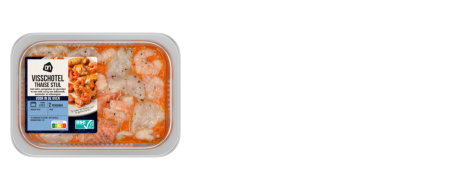

In [276]:
res = fetch_items(db_path, table_name)
# inspect_idx_simple(res, 0)
inspect_idx(res, product_id='wi600555')

# 2. Data cleaning

Het scrapen is niet overal goed gegaan. Die producten verwijderen we.

- Sommige producten hebben geen path naar de foto
- Sommige producten hebben wel een path maar geen foto



In [58]:
def analyze_missing_images(res: list[sqlite3.Row]) -> None:
    """Analyze missing images in the product list."""
    missing_path_value = list()
    missing_img = list()
    for r in map(dict, res):
        if r["image_path"]:
            path = os.path.join("data", r["image_path"])
            if not os.path.exists(path):
                missing_img.append(r["product_id"])
        else:
            missing_path_value.append(r["product_id"])

    print(f"Number of missing image paths: {len(missing_img)}")
    print(f"Number of missing image files: {len(missing_path_value)}")
    return missing_img, missing_path_value

In [59]:
def remove_products_without_image_path(db_path: str, table_name: str) -> None:
    """Remove products without image paths from the database."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(f"DELETE FROM {table_name} WHERE image_path IS NULL")
    conn.commit()
    conn.close()

In [60]:
def remove_products_without_images(
    db_path: str, table_name: str, product_ids: list[str]
) -> None:
    """Remove products without images from the database."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    placeholders = ",".join("?" for _ in product_ids)
    sql = f"DELETE FROM {table_name} WHERE product_id IN ({placeholders})"
    cursor.execute(sql, product_ids)

    conn.commit()
    conn.close()

In [61]:
res = fetch_items(db_path, table_name)
print("Verzamelde items:", len(res))
missing_img, _ = analyze_missing_images(res)

Verzamelde items: 22241
Number of missing image paths: 0
Number of missing image files: 75


In [62]:
remove_products_without_image_path(db_path, table_name)
remove_products_without_images(db_path, table_name, missing_img)

In [63]:
res = fetch_items(db_path, table_name)
print("Verzamelde items:", len(res))
missing_img, _ = analyze_missing_images(res)

Verzamelde items: 22166
Number of missing image paths: 0
Number of missing image files: 0


# xxx Converteren data naar tensors

### Foto's

Voor het converteren van foto's gebruik ik Resnet50; een pretrained image model. Er zijn meerdere versies. Resnet50 is gemiddeld qua grootte. 

De laatste layer geeft een kans voor wat er op de foto te zien is. Dat gebruik ik niet. In plaats daarvan gebruik ik de voorlaatste layer, die een representatie geeft van de foto. De representatie wordt daarna vergeleken met dat van andere foto's.

In [64]:
class ImageDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
        self.transform = v2.Compose(
            [
                v2.Resize(size=(224, 224)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
            ]
        )

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

    def __len__(self):
        return len(self.paths)


res = fetch_items(db_path, table_name)
img_paths = [os.path.join("data", r["image_path"]) for r in map(dict, res)]
product_ids = [r["product_id"] for r in map(dict, res)]
dataset = ImageDataset(img_paths)
loader = DataLoader(dataset, batch_size=128, pin_memory=True)  

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [66]:
def get_img_tensors(max_batches: int = -1) -> torch.Tensor:
    # Alle varianten: 18, 34, 50, 101, 152
    model = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
    # Remove the final classification layer
    model.fc = torch.nn.Identity()
    model = model.to(device).eval()

    all_feats = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i == max_batches:
                break
            print(i)  # progress
            
            batch = batch.to(device)
            feats = model(batch)
            # maak lengte 1, zodat cosine similarity sneller
            feats = torch.nn.functional.normalize(feats, dim=1)  
            all_feats.append(feats.cpu())            

    all_feats = torch.cat(all_feats)
    return all_feats

In [ ]:
# # takes approx 5 minutes
# all_feats = get_img_tensors(max_batches=-1)
# all_feats.shape

Using cache found in C:\Users\ADMINVIVO/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ADMINVIVO\Desktop\product_matching_demo\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMINVIVO\Desktop\product_matching_demo\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


torch.Size([22166, 2048])

In [ ]:
path = os.path.join("data", "img_data.pkl")

# img_df = pd.DataFrame(all_feats.numpy(), index=product_ids)
# joblib.dump(img_df, path)

img_df = joblib.load(path)
all_feats = img_df.values
all_feats.shape

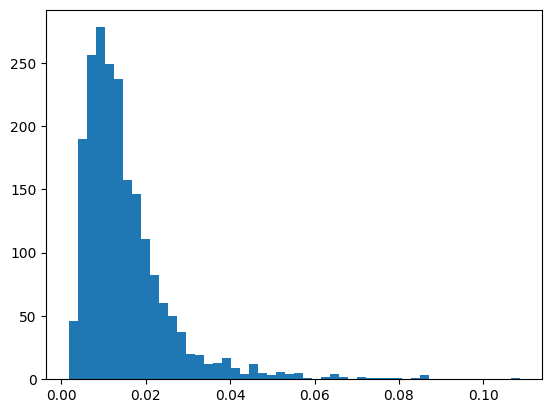

In [178]:
# check if all dimensions are same order of magnitude
plt.hist(img_df.mean(), bins=50)
plt.show()

In [179]:
def plot_random_elements_tensor(tensor: np.array, n=1_000) -> None:
    """Plot random elements from a tensor."""
    subset = np.random.choice(
        tensor.flatten(), size=min(n, prod(tensor.shape)), replace=False
    )
    plt.hist(subset, bins=50)
    plt.show()

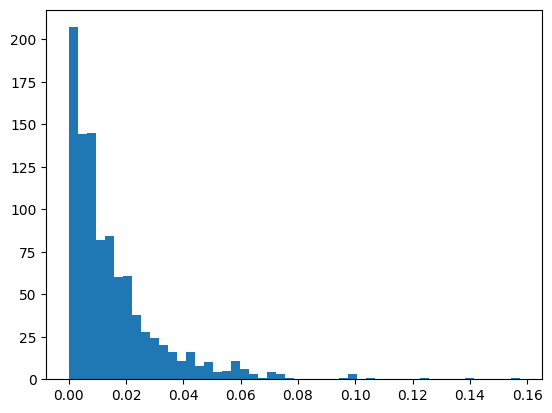

In [89]:
plot_random_elements_tensor(all_feats)

In [91]:
img_sim = cosine_similarity(all_feats)
img_sim.shape

(22166, 22166)

In [ ]:
# same result
# img_sim2 = np.matmul(all_feats.numpy(), all_feats.numpy().T)
# img_sim2.shape
# img_sim - img_sim2

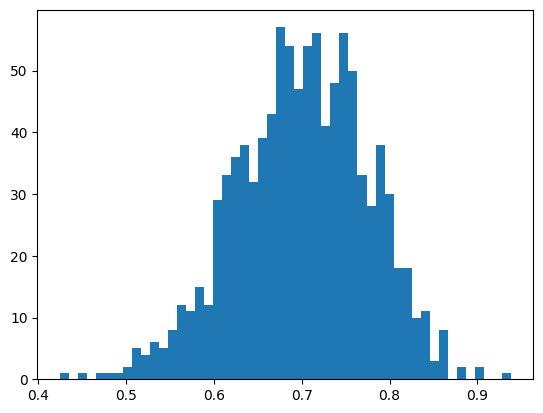

In [ ]:
# takes 40s
plot_random_elements_tensor(img_sim)

In [ ]:
# remove the diagonal
np.fill_diagonal(img_sim, np.nan)

In [94]:
# idx = 0

# small_to_large_ids = np.argsort(img_sim[idx,:])
# img_sim[idx, small_to_large_ids]

In [209]:
def get_top_match_product_ids(idx, similarity_matrix, top=10):
    best = sorted(
        zip(product_ids, similarity_matrix[idx, :], np.arange(len(product_ids))),
        key=lambda x: x[1],
    )[-top:]

    # reverse order: most similar first
    return best[::-1]


def plot_products(best: list[str], size=(2, 2), scores=None) -> None:
    """Plot images for a list of product IDs."""
    for product_id, score, _ in best:
        print(f"{score=}")
        plot_image_path(os.path.join("data", "img", f"{product_id}.jpg"), size=size)


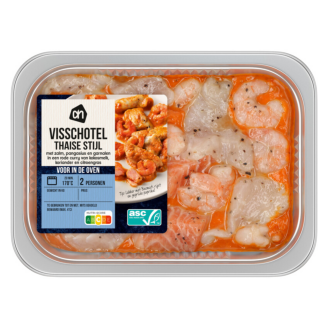

score=np.float32(0.9347773)


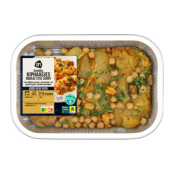

score=np.float32(0.92691904)


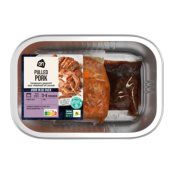

score=np.float32(0.9223532)


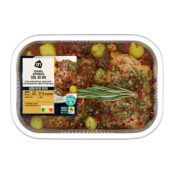

score=np.float32(0.92152685)


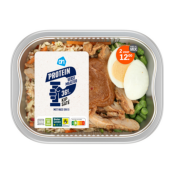

score=np.float32(0.92124385)


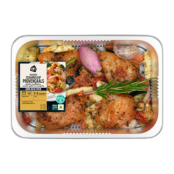

score=np.float32(0.921039)


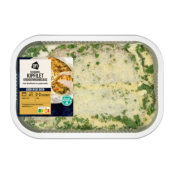

score=np.float32(0.9187789)


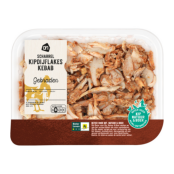

score=np.float32(0.9161339)


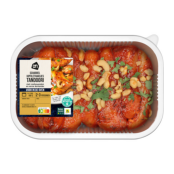

score=np.float32(0.9152647)


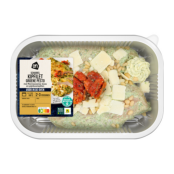

score=np.float32(0.9112116)


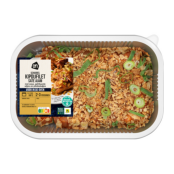

In [210]:
best = get_top_match_product_ids(0, img_sim, top=10)

# product zelf
plot_image_path(os.path.join("data", "img", f"{product_ids[0]}.jpg"), size=(4, 4))
# best matches
plot_products(best)

### Voedingswaarde

In [102]:
def parse_all_nutrition_tables(items, limit=-1):
    """Limit = -1, means no limit."""
    all_nutritions = []
    for i, item in enumerate(items):
        if i % 1000 == 0:
            print(i)  # progress
        if i == limit:
            break

        dd = dict(item)
        if dd["nutrition_table"]:
            new = html_table_to_row(dd["nutrition_table"], dd["product_id"])
        else:
            new = pd.DataFrame(index=[dd["product_id"]])  # empty df
        all_nutritions.append(new)

    return pd.concat(all_nutritions)

In [ ]:
# # takes 1.5 minutes
# voeding_df = parse_all_nutrition_tables(res, limit=-1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [145]:
path = os.path.join("data", "voeding_data.pkl")

# joblib.dump(voeding_df, path)

voeding_df = joblib.load(path)

In [146]:
# # Slechts een paar voedingswaardes komen vaak voor. Die gebruiken we voor de tensor

# voeding_df.columns
voeding_df.notna().sum().sort_values(ascending=False).head(10)

Energie                12935
Koolhydraten           12757
Vet                    12750
Eiwitten               12741
waarvan verzadigd      12734
Zout                   12677
waarvan suikers        12607
Voedingsvezel           8775
waarvan onverzadigd     4844
Calcium                  571
dtype: int64

In [147]:
keep = [
    "Energie",
    "Koolhydraten",
    "waarvan suikers",
    "Vet",
    "waarvan verzadigd",
    "waarvan onverzadigd",
    "Eiwitten",
    "Voedingsvezel",
    "Zout",
]

In [148]:
voeding_df = voeding_df[keep]

In [149]:
voeding_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22166 entries, wi600555 to wi425971
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Energie              12935 non-null  float64
 1   Koolhydraten         12757 non-null  float64
 2   waarvan suikers      12607 non-null  float64
 3   Vet                  12750 non-null  float64
 4   waarvan verzadigd    12734 non-null  float64
 5   waarvan onverzadigd  4844 non-null   float64
 6   Eiwitten             12741 non-null  float64
 7   Voedingsvezel        8775 non-null   float64
 8   Zout                 12677 non-null  float64
dtypes: float64(9)
memory usage: 1.7+ MB


In [150]:
voeding_df.describe()

,Energie,Koolhydraten,waarvan suikers,Vet,waarvan verzadigd,waarvan onverzadigd,Eiwitten,Voedingsvezel,Zout
count,12935.000000,12757.000000,12607.000000,12750.000000,12734.000000,4844.000000,12741.000000,8775.000000,12677.000000
mean,972.002589,25.540231,11.764244,12.004726,4.251710,8.725898,6.832337,2.956688,1.177508
std,801.937029,26.976008,18.485224,16.869345,7.184793,13.087241,8.027596,4.513775,4.668478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,252.000000,3.800000,0.800000,0.300000,0.100000,0.400000,0.800000,0.400000,0.030000
50%,804.000000,12.000000,3.500000,4.200000,1.100000,4.300000,4.600000,1.600000,0.280000
75%,1561.500000,49.000000,11.800000,19.000000,5.500000,11.000000,9.600000,3.600000,1.080000
max,3768.000000,105.000000,105.000000,100.000000,94.000000,88.000000,86.000000,91.000000,99.900000


In [151]:
voeding_df.mean()

Energie                972.002589
Koolhydraten            25.540231
waarvan suikers         11.764244
Vet                     12.004726
waarvan verzadigd        4.251710
waarvan onverzadigd      8.725898
Eiwitten                 6.832337
Voedingsvezel            2.956688
Zout                     1.177508
dtype: float64

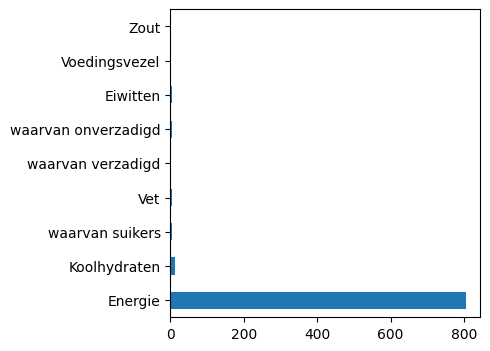

In [152]:
voeding_df.median().plot.barh(figsize=(4, 4))
plt.show()

In [ ]:
pre_process = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]
).set_output(transform="pandas")

# # Volgorde van stappen omdraaien kan, maar dan moet er geimpute worden met mean.
# # Resultaat is dat producten zonder voedingswaarde een similarity van 0 hebben met elk ander product. Dit is ondanks dat ze een identieke vector hebben, maar de vector is praktisch nul in elke dimensie.
#
# pre_process = Pipeline(
#     steps=[
#         ("imputer", SimpleImputer(strategy="mean")),
#         ("scaler", StandardScaler()),
#     ]
# ).set_output(transform="pandas")

scaled = pre_process.fit_transform(voeding_df)

In [154]:
scaled.describe()

,Energie,Koolhydraten,waarvan suikers,Vet,waarvan verzadigd,waarvan onverzadigd,Eiwitten,Voedingsvezel,Zout
count,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04,2.216600e+04
mean,2.051554e-17,2.564442e-17,-2.051554e-17,-3.590219e-17,2.564442e-18,1.025777e-17,-5.128884e-18,7.693326e-18,1.025777e-17
std,7.639226e-01,7.586482e-01,7.541748e-01,7.584400e-01,7.579640e-01,4.674856e-01,7.581723e-01,6.292014e-01,7.562657e-01
min,-1.212115e+00,-9.468129e-01,-6.364386e-01,-7.116576e-01,-5.917884e-01,-6.668173e-01,-8.511396e-01,-6.550740e-01,-2.522352e-01
25%,-4.988148e-01,-6.057557e-01,-4.903702e-01,-5.515977e-01,-4.943566e-01,0.000000e+00,-4.275840e-01,-1.011823e-01,-2.158193e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.853582e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.486690e+00,2.945687e+00,5.043999e+00,5.216487e+00,1.249191e+01,6.057983e+00,9.862327e+00,1.950658e+01,2.114745e+01


In [ ]:
voeding_sim = cosine_similarity(scaled)

# zelfde resultaat
# normalized = torch.nn.functional.normalize(torch.Tensor(scaled), dim=1) 
# voeding_sim2 = np.matmul(normalized, normalized.T)
# voeding_sim - voeding_sim2.numpy()

# verwijder similarity met zichzelf
np.fill_diagonal(voeding_sim, np.nan)
voeding_sim.shape

(22166, 22166)

Nul komt vaak voor omdat niet elke product een voedingswaarde tabel heeft. Missende voedingswaardes zijn eerst geschaald, en daarna zijn missende voedingswaardes geimpute met 0. Cosine similarity met nul vector is nul.

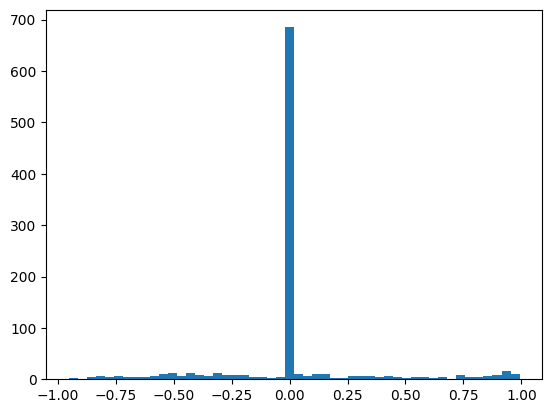

In [ ]:
plot_random_elements_tensor(voeding_sim)

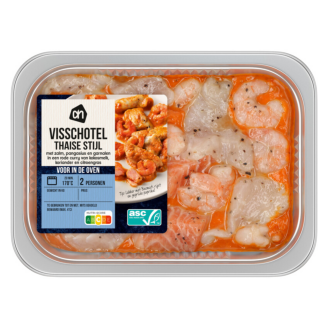

score=np.float64(0.9757127281242569)


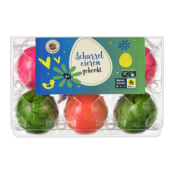

score=np.float64(0.9726882587673109)


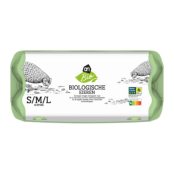

score=np.float64(0.9726882587673109)


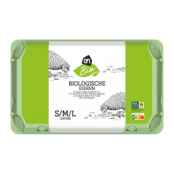

score=np.float64(0.9726882587673109)


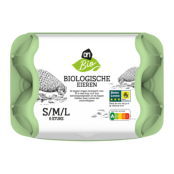

score=np.float64(0.9726882587673109)


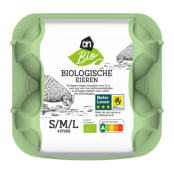

score=np.float64(0.9726882587673109)


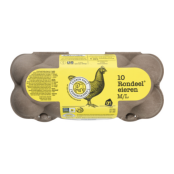

score=np.float64(0.9726882587673109)


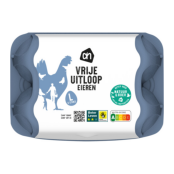

score=np.float64(0.9726882587673109)


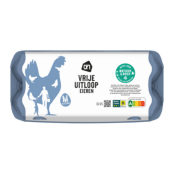

score=np.float64(0.9726882587673109)


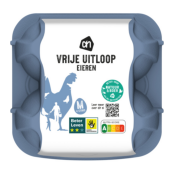

score=np.float64(0.9726882587673109)


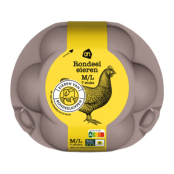

In [156]:
idx = 0
best = get_top_match_product_ids(idx, voeding_sim, top=10)

# product zelf
plot_image_path(os.path.join("data", "img", f"{product_ids[idx]}.jpg"), size=(4, 4))
# best matches
plot_products(best)


# Text

In [280]:
all_texts = [f"{r['title']}\n{r['description']}" for r in res]

In [ ]:
# # creating embeddings takes 50s
# text_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = text_model.encode(all_texts)

path = os.path.join("data", "text_data.pkl")

# text_df = pd.DataFrame(embeddings, index=product_ids)
# joblib.dump(text_df, path)

text_df = joblib.load(path)

In [295]:
text_sim = cosine_similarity(text_df)

np.fill_diagonal(text_sim, np.nan)

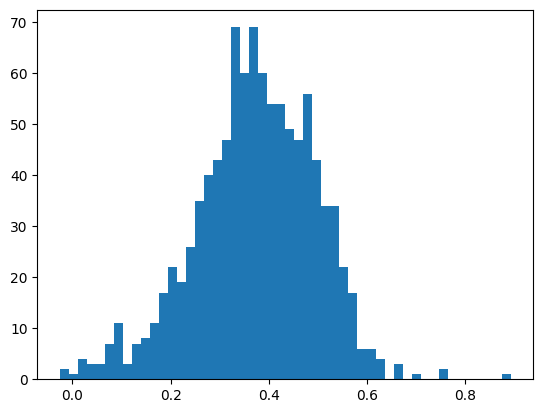

In [296]:
plot_random_elements_tensor(text_sim)

# Combineer similarity measures

Simpelweg optellen of gemiddelde van scores is mogelijk. Enkele kanttekeningen:

- Measures hebben niet dezelfde grootte. Een 0.8 bij de ene measure is niet een 0.8 bij de ander; verschillende percentielen. 
- Scores kunnen worden geschaald zodat de elke measure zelfde bandbreedte heeft.
- Ipv nominale scores percentiele gebruiken.
- Een product zonder voedingswaarde data heeft altijd een voedings similarity van 0. Dot product met nul is nul.

## Verbetering

Maak simpel machine learning model die gewichten bepaalt aan de hand van gevalideerde data. Gebruik bijvoorbeeld LogisticRegression, evt zonder constante (het is niet logisch als een measure altijd averechts werkt).

In [297]:
img_sim.shape, voeding_sim.shape, text_sim.shape

((22166, 22166), (22166, 22166), (22166, 22166))

In [298]:
sum_sim = img_sim + voeding_sim + text_sim
mean_sim = sum_sim / 3

In [ ]:
sims = [
    ("img", img_sim),
    ("voeding", voeding_sim),
    ("text", text_sim),
    # ("sum", sum_sim)
    ("mean", mean_sim),
]

# takes 2 minutes
# for name, sim in sims:
#     print(name)
#     print(np.nanmin(sim), np.nanmax(sim))


# img
# 0.21459158 1.0000005
# voeding
# -1.0 1.0000000000000004
# text
# -0.2288084 1.0000005
# mean
# -0.1482529889944455 0.9994293848673502

img
0.21459158 1.0000005
voeding
-1.0 1.0000000000000004
text
-0.2288084 1.0000005
mean
-0.1482529889944455 0.9994293848673502


In [258]:
# np.nanargmax(sum_sim)
# np.unravel_index(36956469, sum_sim.shape)
# sum_sim[1667, 5747]
# inspect_idx_simple(res, 1667)
# inspect_idx_simple(res, 5747)

('(wi600555) AH Ovenschotel visschotel Thaise stijl \n'
 ' Heerlijke ovenschotel met zalm, pangasius en garnalen gemarineerd in een '
 'rode Thaise stijl curry. Kan met de aluminium schaal zo in de oven, snel en '
 'makkelijk te bereiden Te bereiden in de oven op 170°C\u200b Lekker met: '
 'Basmati rijst en gegrilde paprika!')


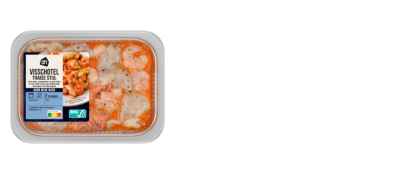

('(wi602186) AH Oven scharrel kippendijen coq au vin \n'
 ' Een overheerlijke winterse ovenschotel met zachtgegaarde kippendijen in een '
 'rode wijn saus, met Amsterdamse uitjes en rozemarijn Een echt klassiek Frans '
 'gerecht! Gemakkelijk te bereiden in de oven op 180 graden voor 40 minuten '
 'Geschikt voor 2 tot 3 personen Serveertip: Lekker met romige aardappelpuree '
 'en haricots verts')


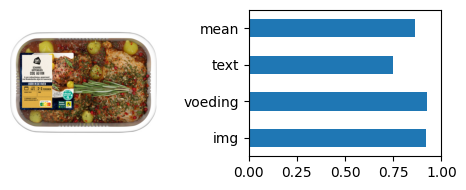

('(wi600468) AH Ovenschotel scharrel kip Koreaanse stijl \n'
 ' Een smaakvolle koreaanse ovenschotel met scharrel kipdijfilet gemarineerd '
 'in gochujang saus met geraspte kaas en bosuitjes\u200b Gemakkelijk te '
 'bereiden \u200bin de oven Serveertip: Lekker met noedels Te bereiden in de '
 'oven op 180°C\u200b')


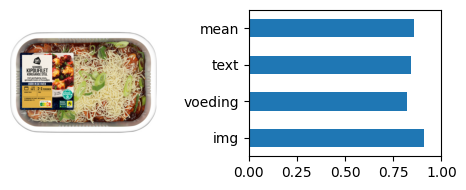

('(wi525353) AH Ovenschotel varkensoester \n'
 ' Mals varkensvlees met provencaalse kruiding en een heerlijke roomsaus Met '
 'aardappelen en groente een complete maaltijd Van 1 ster Nederlands Beter '
 'Leven varkensvlees Kan direct in de oven in bijgeleverde aluminium schaal')


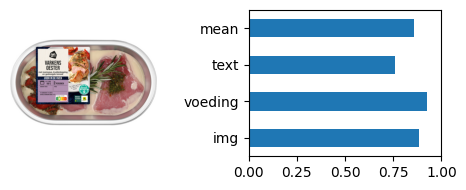

('(wi418194) AH Ovenschotel beenham naturel \n'
 ' Met deze licht gepekelde beenham uit de oven zet je een topstuk op de '
 'eettafel. Heerlijk op z’n Hollands met aardappeltjes en groente. De ham is '
 'heerlijk zacht en mals van smaak\u200b Van 1 ster Nederlands Beter Leven '
 'varkensvlees\u200b Kan direct in de oven in bijgeleverde aluminium '
 'schaal\u200b Met aardappelen en groente een complete maaltijd\u200b Ook een '
 'prachtig stuk vlees tijdens de feestdagen.')


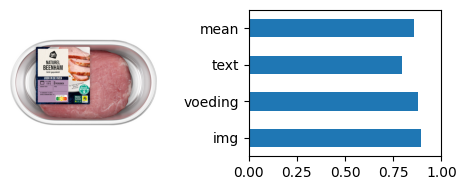

('(wi565910) AH Ovenschotel varkenshaas medaillons spek \n'
 ' Varkenshaas medaillons met spek omwikkeld en een topping van italiaanse '
 'kaas. Serveer de medaillons met de roomsaus die in de ovenschaal zit. Kan '
 'direct in de oven in bijgeleverde aluminium schaal\u200b. Lekker en slechts '
 '25 minuten in de oven. Tip: heerlijk met gestoofde groente en gebakken '
 'aardappelen.')


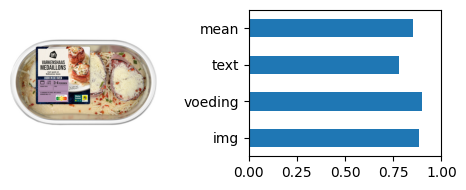

<Figure size 640x480 with 0 Axes>

In [301]:
idx = 0  # 1667
best = get_top_match_product_ids(idx, sum_sim, top=5)

# # plot product zelf
# plot_image_path(os.path.join("data", "img", f"{product_ids[idx]}.jpg"), size=(4, 4))
# # best images best matches
# plot_products(best)

# plot image + best matches
inspect_idx(res, idx, sims=sims, best=best)